## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

In [2]:
#Load basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns; sns.set()

#Load the faces dataset (explanation to tweaks at the bottom)
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=100)

#Check who's mug will appear by printing labels
print(faces.target_names)
print(faces.images.shape)


['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


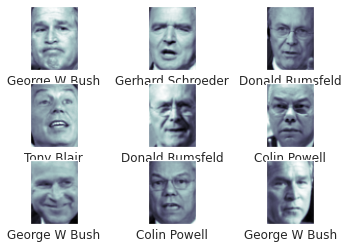

In [3]:
#Check those guys out :()

fig, ax = plt.subplots(3,3)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [5]:
#Create pipeline: a. import SVM package; b.import PCA to extract
#principal components to feed into the SVM classifier; c. import pipeline package

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

#Generate Principal components
pca = RandomizedPCA(n_components=100, whiten=True, random_state=42)
#Generate SVC
svc = SVC(kernel='rbf', class_weight='balanced')
#Generate Pipeline
model = make_pipeline(pca, svc)

In [8]:
#To test classifier output, create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [9]:
#Use grid search validation to check parameter combinations

#load gridsearch
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 35.1 s, sys: 25.5 s, total: 1min
Wall time: 32.8 s
{'svc__C': 1, 'svc__gamma': 0.005}


In [11]:
#predict labels
model = grid.best_estimator_
yfit = model.predict(Xtest)

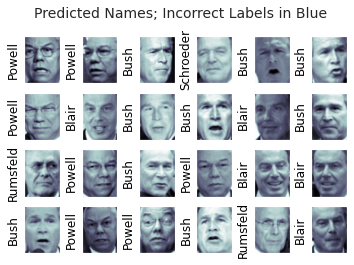

In [12]:
#Check test images and their values
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'blue')
fig.suptitle('Predicted Names; Incorrect Labels in Blue', size=14);

In [13]:
#check estimator accuracy
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.91      0.95      0.93        64
  Donald Rumsfeld       0.77      0.84      0.81        32
    George W Bush       0.95      0.91      0.93       127
Gerhard Schroeder       0.81      0.86      0.83        29
       Tony Blair       0.93      0.85      0.89        33

         accuracy                           0.90       285
        macro avg       0.87      0.88      0.88       285
     weighted avg       0.90      0.90      0.90       285



In [14]:
#After changing the number of faces and n-components
#a few times, I settled to 80 faces min and 100 n_components.
#This produced a 90% accuracy score while providing a good-sized
#test sample to check the model against.

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 90% or more on a **holdout** dataset you kept for yourself.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#import modules
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for file in os.listdir("/content/drive/MyDrive/5_1 words popcorn/data"):
    print(file)


IMDB Dataset.csv
labeledTrainData.tsv.zip
sampleSubmission.csv
testData.tsv.zip
unlabeledTrainData.tsv.zip


In [17]:
#Set some matplotlib configs for visualization
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [42]:
#import data. As advised by Jasleen, only using the Labeled data file as to not crash out.
#so this data will be used for both the train and test datasets.
usecols = ['sentiment','review']
df = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/5_1 words popcorn/data/labeledTrainData.tsv.zip',
    usecols=usecols, sep='\t')

In [43]:
df.info()
display(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [51]:
def clean_review( raw_review ):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    #4. Convert stop words to a set
    stops = set(stopwords.words("english"))
    #5. remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #6. Join words back into one string separated by space
    return(" ".join( meaningful_words ))
    
df['review2'] = df.review.apply(clean_review)

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(
    analyzer = "word",tokenizer = None, preprocessor = None,
    stop_words = None, max_features = 5000)

train_data_features = vectorizer.fit_transform(df['review']).toarray()


In [86]:
x_train, x_test, y_train, y_test=train_test_split(
    train_data_features, df["sentiment"], test_size=0.2, random_state=0)

In [87]:
import lightgbm as lgbm

In [92]:
gbdt = lgbm.LGBMClassifier(
    boosting='goss',
    n_estimators=200,
    max_dept=-1,
    feature_fraction=0.8,
    #bagging_fraction=0.7,
    #bagging_freq=1
)


In [93]:
gbdt.fit(x_train, y_train)
gbdt.score(x_test, y_test)
#sweet score!

0.8764

In [94]:
gbdt.score(x_train, y_train)
#woohoo : )

0.95165